In [16]:
# this code can read data and metadata in 384-well format and do the math
# it also asks the user for the name of the data and metadata file names and names the output files accordingly
# this is basically a cleaned up version of v3.0
# + v3.2 can accept a whole input folder of .csv files.
# unfortunately, some comments got lost after modification by ChatGPT


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def create_folder():
    input_path = os.getcwd() + "/"
    folder_path = input_path + "output/"
    if not os.path.exists(folder_path):
        output_folder = os.makedirs(folder_path)
        print(f"Folder created at {folder_path}")
    else:
        print(f"Folder already exists at {folder_path}")
    return folder_path, input_path

def datafiles(input_path):
    # Get all CSV files in the specified folder excluding metadata.csv
    csv_files = [file for file in os.listdir(input_path) if file.endswith('.csv') and file != 'metadata.csv']
    return csv_files

def detect_delimiter(file_path):
    with open(file_path, 'r') as file: # 'r' = read-only; 
        # Read the first few lines to detect the delimiter
        sample_lines = [file.readline() for _ in range(5)]
        # Once the code block is exited (either normally or due to an exception), the with statement ensures that the file is closed, releasing any system resources associated with it
    if any(',' in line for line in sample_lines):
        return ','
    elif any(';' in line for line in sample_lines):
        return ';'

def prepare_data(data_input):
    delimiter = detect_delimiter(data_input)
    data = pd.read_csv(data_input, sep=delimiter, index_col=0)
    data_T = data.T
    data_T = data_T.reset_index()
    data_T = data_T.rename(columns={'index': 'well'})
    data_T_melt = pd.melt(data_T, id_vars=['well'], var_name='OD')
    data_T_melt['well'] = data_T_melt['OD'] + data_T_melt['well']
    data_T_melt = data_T_melt[['well', 'value']]
    data_T_melt = data_T_melt.rename(columns={'value': 'OD'})
    print(f"Quality control of transformed data ({data_input}):\n")
    print(data_T_melt)
    return data_T_melt, data

def prepare_metadata(metadata_input):
    delimiter = detect_delimiter(metadata_input)
    metadata = pd.read_csv(metadata_input, sep=',', index_col=0)
    metadata_T = metadata.T
    meatadata_T = metadata_T.reset_index()
    metadata_T = meatadata_T.rename(columns={'index': 'well'})
    metadata_T_melt = pd.melt(metadata_T, id_vars=['well'], var_name='condition')
    metadata_T_melt['well'] = metadata_T_melt['condition'] + metadata_T_melt['well']
    metadata_T_melt = metadata_T_melt[['well', 'value']]
    metadata_T_melt = metadata_T_melt.rename(columns={'value': 'condition'})
    print(f"Quality control of transformed metadata ({metadata_input}):\n")
    print(metadata_T_melt)
    return metadata_T_melt

def merge(data, metadata, folder, data_name):
    merged_data = pd.merge(data, metadata, on='well')
    merged_data = merged_data.drop("well", axis=1)
    merged_data = merged_data.sort_values(by='condition', ascending=False)
    merged_data.to_csv(os.path.join(folder, f'{data_name}_merged_data.csv'), index=False)
    print(f"Quality control of merged data ({data_name}_merged_data.csv):\n")
    print(f"Saved at: {os.path.join(folder)}")
    return merged_data

def group_data(data_merged):
    grouped_data = data_merged.groupby('condition').agg({'OD': ['mean', 'std']})
    grouped_data.reset_index(inplace=True)
    grouped_data.columns = ['condition', 'mean_OD', 'std_OD']
    print("Quality control of mean and std. (grouped_data):\n")
    print(grouped_data)
    return grouped_data

def plot_BarGraph(data_grouped, folder_path, data_name, fig_size_bar, dpi):
    plt.bar(data_grouped['condition'], data_grouped['mean_OD'], yerr=data_grouped['std_OD'], capsize=5)
    plt.xlabel('Conditions')
    plt.ylabel('Mean OD Value')
    plt.title('Mean OD Values with Standard Deviation')
    plt.xticks(rotation=90)
    plt.gcf().set_size_inches(fig_size_bar)
    plt.savefig(os.path.join(folder_path, f'{data_name}_bar-graph.png'), dpi=dpi)
    plt.show()

def generate_heatmap(data, folder_path, data_name, fig_size_heat, dpi):
    plt.figure(figsize=fig_size_heat)
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True, square=False)
    plt.title(f'{data_name}_Plate Heatmap')
    plt.savefig(os.path.join(folder_path, f'{data_name}_heat-map.png'), dpi=dpi)
    plt.show()

def main():
    fig_size_bar = (10, 20)
    fig_size_heat = (20, 10)
    dpi = 400
    folder_path, input_path = create_folder()
    csv_files = datafiles(input_path)

    for csv_file in csv_files:
        data_T_melt, data = prepare_data(os.path.join(input_path, csv_file))
        metadata_T_melt = prepare_metadata(os.path.join(input_path, 'metadata.csv'))  # Assuming metadata.csv is fixed
        merged_data = merge(data_T_melt, metadata_T_melt, folder_path, csv_file[:-4])
        grouped_data = group_data(merged_data)
        plot_BarGraph(grouped_data, folder_path, csv_file[:-4], fig_size_bar, dpi)
        generate_heatmap(data, folder_path, csv_file[:-4], fig_size_heat, dpi)


In [17]:
# now calculate a z-score
# the .loc function extracts the value from the table at the crossing point of the descriptors
# the .iloc function lets you do the same, but based on integer row and column positions (e.g. 0, 3)
# df.iloc[row_position, column_position], keep in mind that the df is zero-indexed
# this is still very hard coded and does not work for > 2 conditions...
  #  mean_neg = grouped_data.iloc[1, 1]
  #  mean_pos = grouped_data.iloc[0, 1]
  #  std_neg = grouped_data.iloc[1, 2]
  #  std_pos = grouped_data.iloc[0, 2]
  #  z = 1 - (3*(std_pos+std_neg))/(mean_pos-mean_neg)
  #  print(z)
  #  grouped_data.to_csv(os.path.join(folder_path + data_name + '_statistics_data.csv'), index=False)

Folder created at /Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.2_test/output/
Quality control of transformed data (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.2_test/231110_E-coli_endpoint19h_read600nm_180rpm.xpt.csv):

    well     OD
0     A1  0.848
1     A2  1.034
2     A3  0.966
3     A4  0.918
4     A5  1.252
..   ...    ...
379  P20  0.207
380  P21  0.216
381  P22  0.208
382  P23  0.208
383  P24  0.204

[384 rows x 2 columns]
Quality control of transformed metadata (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.2_test/metadata.csv):

    well                 condition
0     A1               300 nL DMSO
1     A2               300 nL DMSO
2     A3               300 nL DMSO
3     A4               300 nL DMSO
4     A5               300 nL DMSO
..   ...                       ...
379  P20  300 nL cipro (133 µg/mL)
380  P21  300 nL cipr

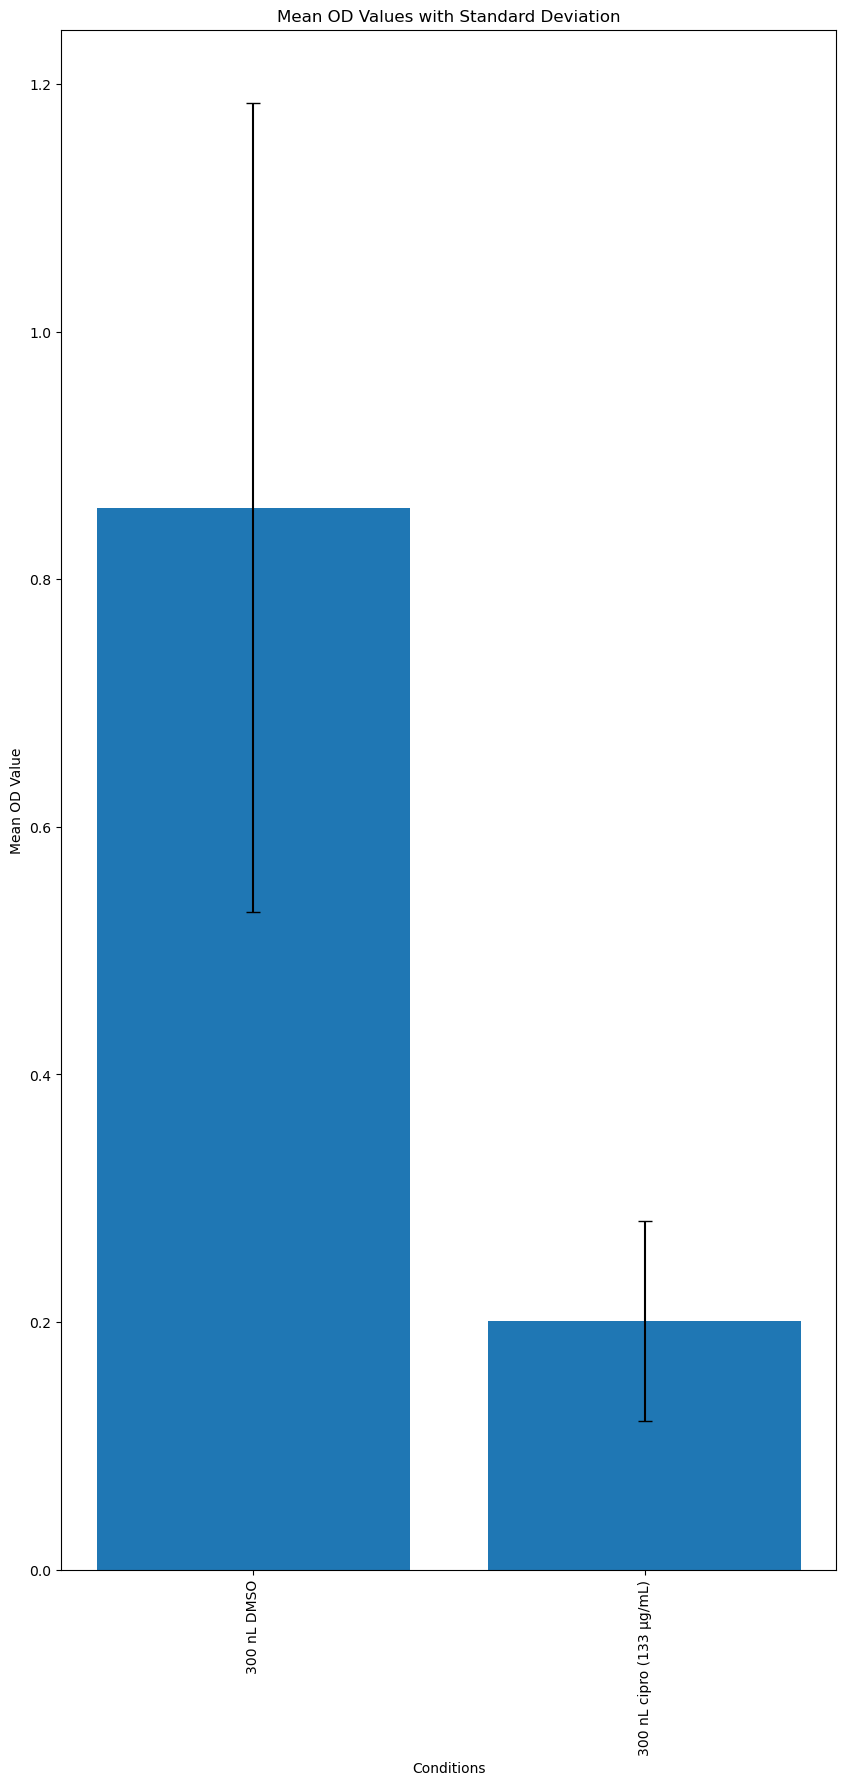

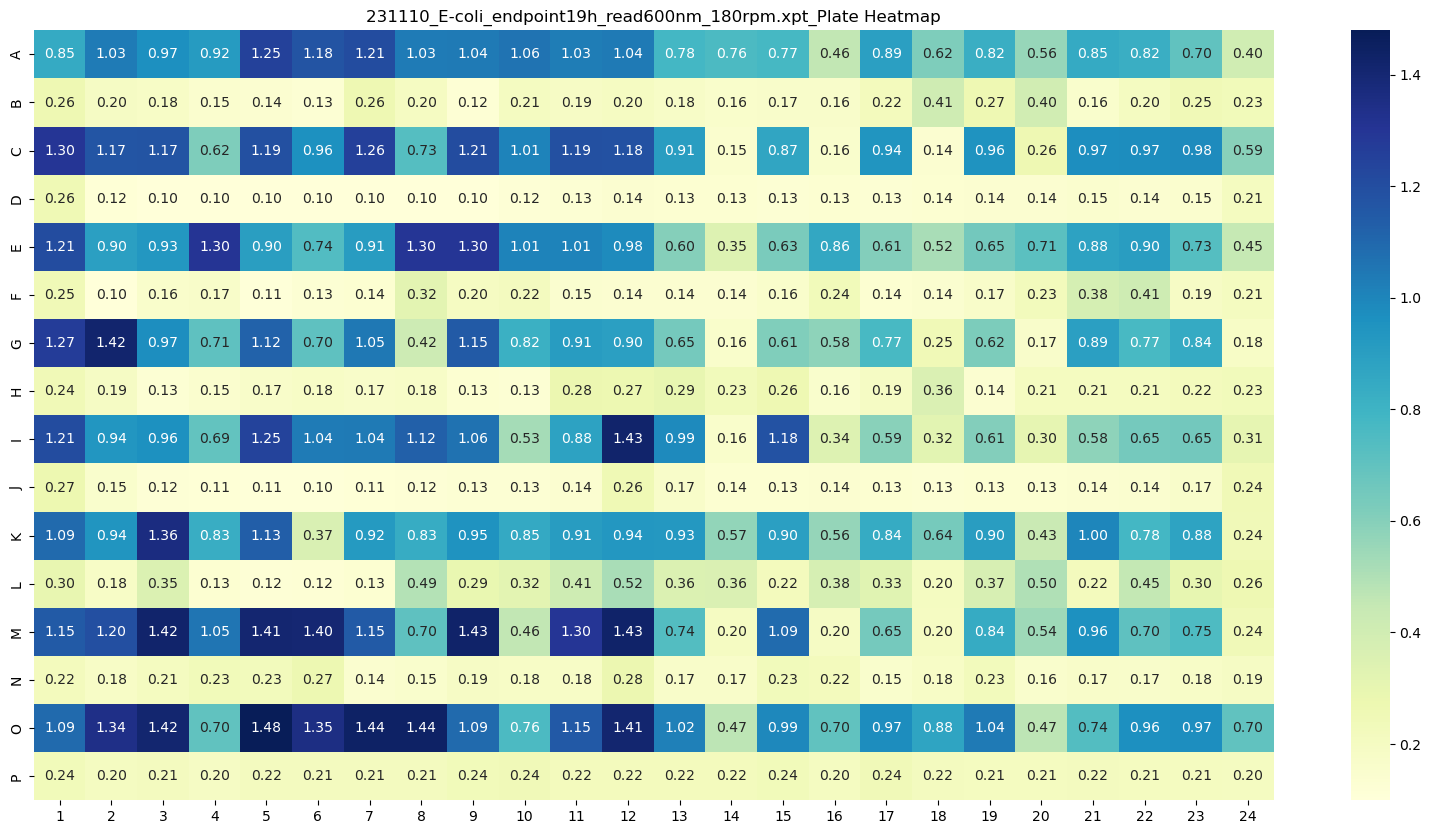

Quality control of transformed data (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.2_test/231110_E-coli_endpoint19h_read600nm_50rpm.xpt.csv):

    well     OD
0     A1  0.929
1     A2  0.884
2     A3  0.883
3     A4  0.837
4     A5  0.932
..   ...    ...
379  P20  0.196
380  P21  0.205
381  P22  0.204
382  P23  0.192
383  P24  0.184

[384 rows x 2 columns]
Quality control of transformed metadata (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.2_test/metadata.csv):

    well                 condition
0     A1               300 nL DMSO
1     A2               300 nL DMSO
2     A3               300 nL DMSO
3     A4               300 nL DMSO
4     A5               300 nL DMSO
..   ...                       ...
379  P20  300 nL cipro (133 µg/mL)
380  P21  300 nL cipro (133 µg/mL)
381  P22  300 nL cipro (133 µg/mL)
382  P23  300 nL cipro (133 µg/mL)
383  P24  300 nL cipro (133 µg/mL)

[384 rows 

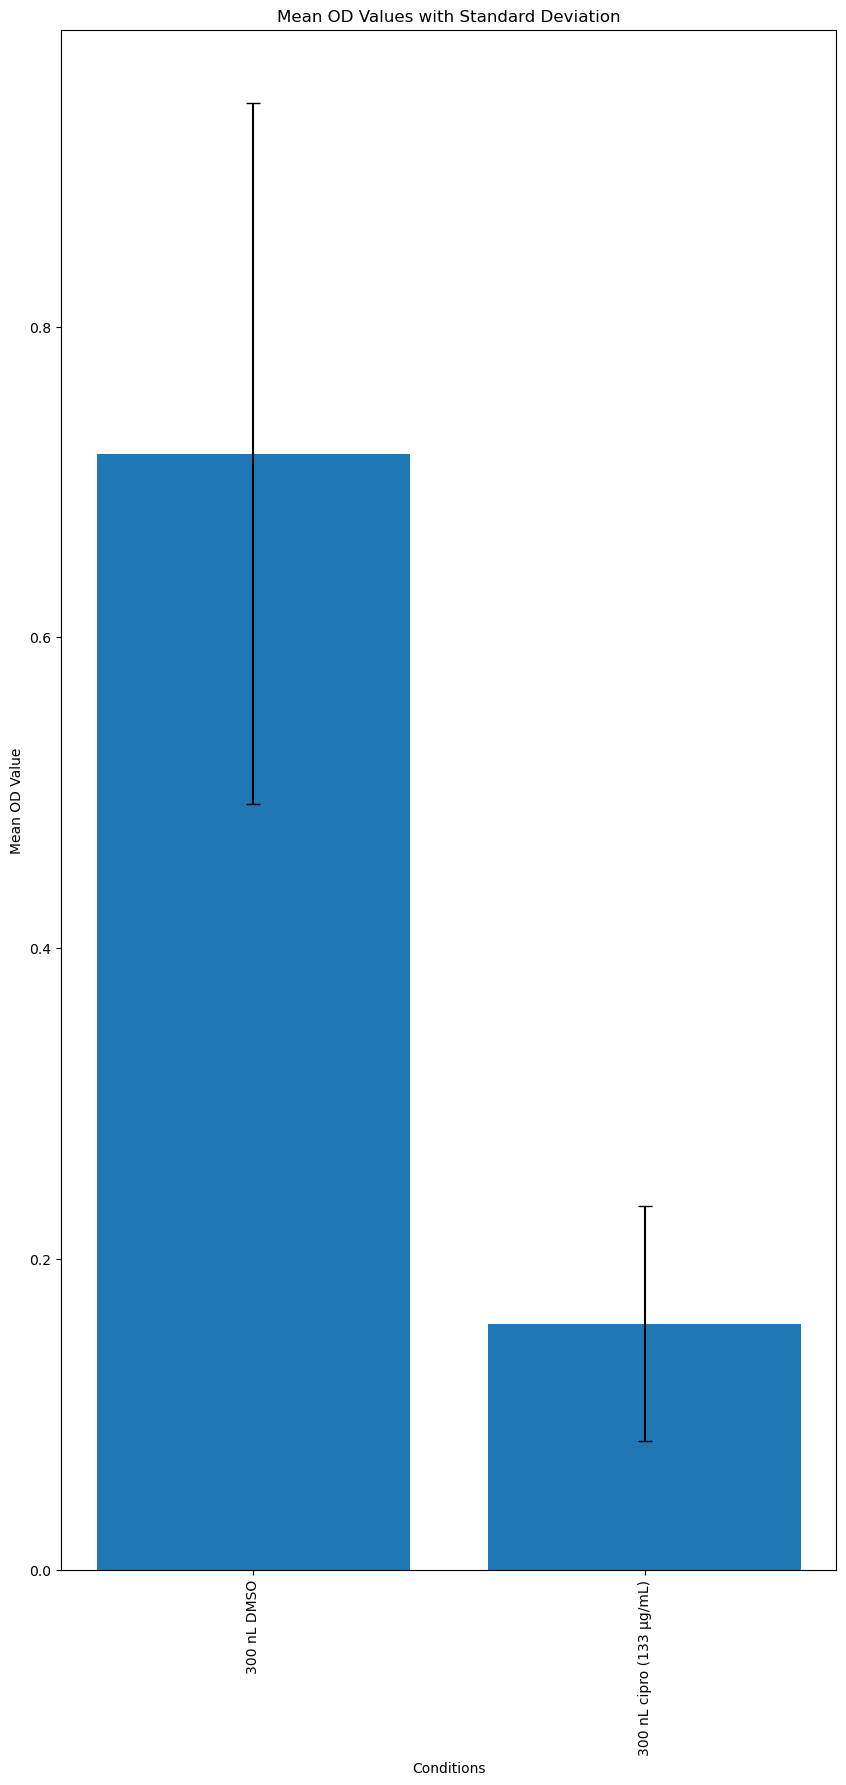

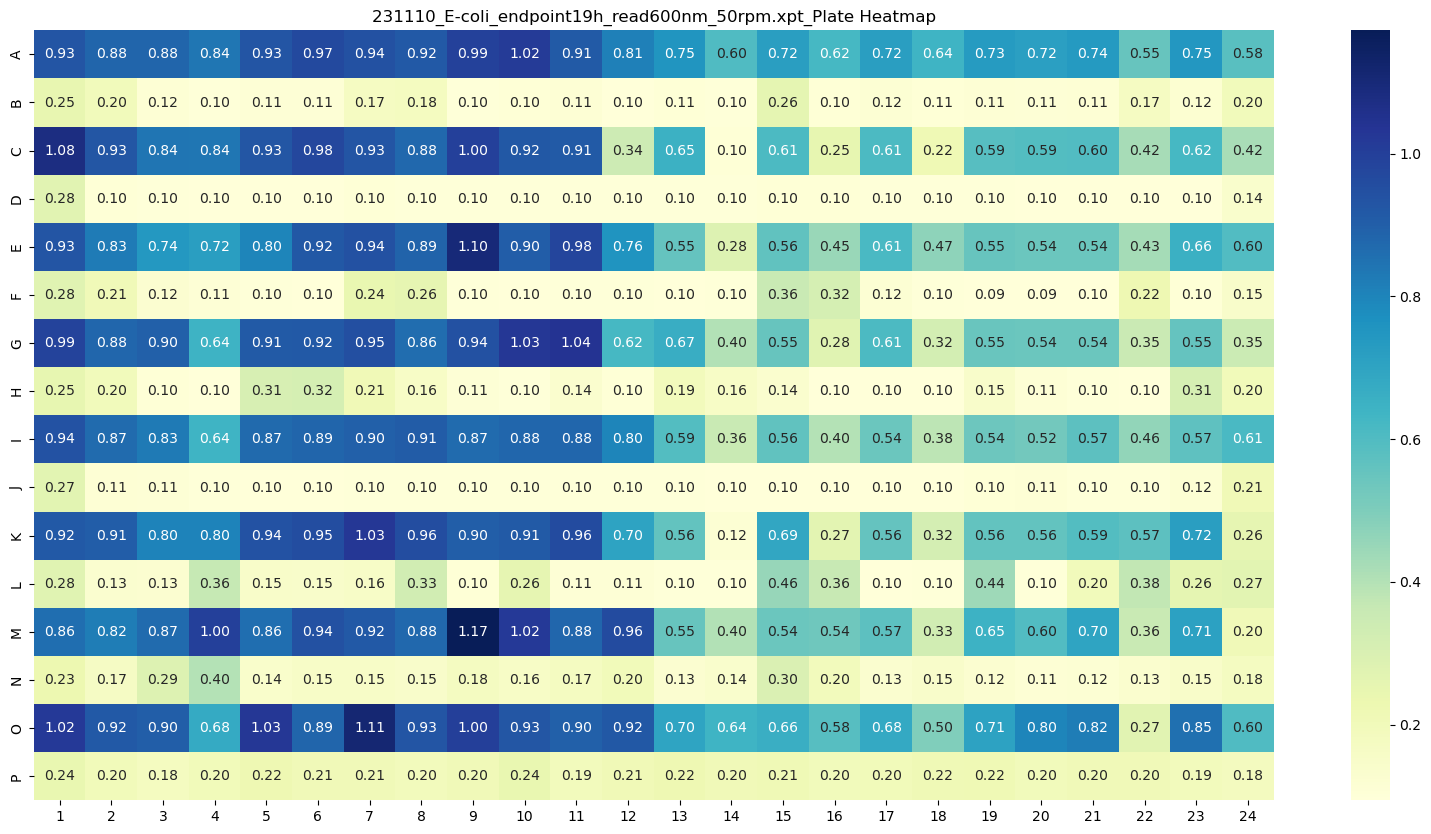

In [18]:
if __name__ == "__main__":
    main()